<Quantity 1.3271244e+11 km3 / s2>

In [100]:
import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy import constants as const
from astropy.time import Time
import matplotlib.pyplot as plt


# Simbolos y constantes 
"""
a = semieje mayor
e = excentricidad
omega = longitud del nodo ascendente
w = argumento del pericentro
i = inclinacion de la orbita
n = movimiento medio
lo = anomalia media en la epoca
tp = tiempo del perihelio
to = tiempo de la epoca
M = la suma de las masas de los cuerpos
"""


import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt

# Simbolos y constantes 
"""
a = semieje mayor
e = excentricidad
omega = longitud del nodo ascendente
w = argumento del pericentro
i = inclinacion de la orbita
n = movimiento medio
lo = anomalia media en la epoca
tp = tiempo del perihelio
to = tiempo de la epoca
M = la suma de las masas de los cuerpos
GM = Parametro gravitacional del sol
"""

# Efemerides
a_tierra = (1.495582533630905E+8*u.km).to('au')
ecc_tierra = 1.694863932474438E-02
omega_tierra = 1.498625963929686E+02*u.deg
w_tierra = 3.146587763491455E+02*u.deg
i_tierra = 4.164075603038432E-03*u.deg 
n_tierra = 1.141204629731537E-05*u.deg/u.s
l0_tierra = 1.817846947871890E+02*u.deg
GM_sol = 132712440041.93938*u.km**3/u.s**2
GM_sol.to("au**3/day**2")


#Transformacion de unidades
omega_tierra = omega_tierra.to('rad')
w_tierra = w_tierra.to('rad')
i_tierra = i_tierra.to('rad')
n_tierra = n_tierra.to('rad/s')
l0_tierra = l0_tierra.to('rad')


## Funciones de la Tierra
def Kepler(E, l, ecc):
    f = E - ecc*np.sin(E) - l
    fprime = 1 - ecc*np.cos(E)
    return f, fprime


def find_iota(t, l0, n, t0,):
    return (l0 + n*(t-t0))


def find_f(e, E):
    root_term = np.sqrt( (1+e)/(1-e) )
    right_side = root_term*np.tan(E/2)
    f = 2*np.arctan(right_side)
    return f


def find_r(a, ecc, E):
    return a*(1 - ecc*np.cos(E))


def find_xyz (r, Om, phi, i):
    x = r*(np.cos(Om)*np.cos(phi) - np.cos(i)*np.sin(Om)*np.sin(phi))
    y = r*(np.sin(Om)*np.cos(phi) + np.cos(i)*np.cos(Om)*np.sin(phi))
    z = r*(np.sin(i)*np.sin(phi))
    return (x, y, z)


def find_norm(vector):
    num = np.sqrt(vector[0].value**2 + vector[1].value**2 + vector[2].value**2)
    return num



## Segundo intento del cometa
def find_velocidad():
    # Se usa el método del punto medio
    h = tiempos_cometa_inicial[1] - tiempos_cometa_inicial[0]
    velocidades_cometa_inicial = [0,0,0]

    for ii in range (3):
        velocidades_cometa_inicial[ii] = (coor_cometa_inicial[2][ii]*u.au - coor_cometa_inicial[0][ii]*u.au) / (2*h) 
    return velocidades_cometa_inicial



## Empiezan funciones del cometa
### ¡¡SUPOSICIÓN!!
## Estamos suponiendo que la inclinacion es constante, y tomamos el promedio
def find_inclination(xyz_vector, r_vector):
    inclinacion_vector = []
    for ii in range (len(xyz_vector)):
        xy0_vector = [xyz_vector[ii][0], xyz_vector[ii][1], 0]   
        dot_product = np.dot(xyz_vector[ii], xy0_vector)
        magnitud_r = r_vector[ii]
        magnitud_rz = np.linalg.norm(xy0_vector)
        inclinacion = np.arccos(dot_product/(magnitud_r*magnitud_rz))
        inclinacion_vector.append(inclinacion)
    return (inclinacion_vector)*u.rad


def find_comet_values():
    return 0

def find_phi_cometa(xyz_vector, r_vector, inclinacion_vector):
    phi_vector = []
    for ii in range (len(xyz_vector)):
        inclinacion = inclinacion_vector
        #z = (xyz_vector[ii][2]*u.au).to('km')
        z = xyz_vector[ii][2]
        #inside = z.value / (r_vector[ii]*np.sin(inclinacion))
        inside = z / (r_vector[ii]*np.sin(inclinacion))
        if inside > 1:
            inside = 1*u.km/u.km
        phi = np.arcsin(inside)
        phi_vector.append(phi)
    return phi_vector


## Parámetros temporales
n_datos = (1*4)
t0 = Time('2023-07-09T00:00:00', scale='tdb', format = 'isot').utc
tf = Time('2024-07-09T00:00:00', scale='tdb', format = 'isot').utc
tiempos_tierra = np.linspace(t0,tf,n_datos)

## Calculo orbita Tierra
plot_tierra_data = np.zeros((3,n_datos))

for ii, t in enumerate(tiempos_tierra):
    ## 1. Hallar iota
    iota_tierra = find_iota(t, l0_tierra, n_tierra, t0)


    ## 2. Solucionar la Ec. de Kepler
    # E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), bracket=[0, iota_tierra.value], method="brentq")
    E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_tierra = find_f(ecc_tierra, E_raiz_tierra)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_tierra = f_tierra + w_tierra


    ## 5. Hallar r
    r_tierra = find_r(a_tierra, ecc_tierra, E_raiz_tierra)


    ## 6. Hallar x, y, z
    coor_tierra = find_xyz (r_tierra, omega_tierra, phi_tierra, i_tierra)
    for jj in range (3):
        plot_tierra_data[jj, ii] = coor_tierra[jj].value



## Cálculo orbita cometa
## Parametros temporales
tiempos_cometa_inicial = [
    Time('2023-07-09T10:00:00', scale='utc', format = 'isot'), Time('2023-07-09T12:00:00', scale='utc', format = 'isot'),
    Time('2023-07-09T14:00:00', scale='utc', format = 'isot'), Time('2023-08-03T11:00:00', scale='utc', format = 'isot'),
    Time('2023-08-15T08:00:00', scale='utc', format = 'isot'), Time('2023-08-21T09:00:00', scale='utc', format = 'isot')]

## Parámetros espaciales
coor_cometa_inicial = [
    [-136.5637561083746,  -58.86174117642695,  0.006477038631585696],
    [-136.52944516728272, -58.8582744676107,   0.006476657161271048],
    [-136.49508281581126, -58.85478559561711,  0.006476273252160792],
    [-123.8254221225029,  -56.75184521313076,  0.006244869528365741],
    [-115.92607005859432, -54.90754850330492,  0.0060419264825281455],
    [-111.38702385389293, -53.724113572894545, 0.0059117034614445335]]


## Hallamos r del cometa
r_cometa_inicial = [np.linalg.norm(coor_cometa_inicial[ii]) for ii in range (6)]
i_cometa = max(find_inclination(coor_cometa_inicial, r_cometa_inicial))
#phi_cometa_inicial = find_phi_cometa(coor_cometa_inicial, r_cometa_inicial, i_cometa)

velocidades_cometa_inicial = find_velocidad()
e_aux = 0.5*find_norm(velocidades_cometa_inicial)**2*u.au**2/u.day**2 - GM_sol/(r_cometa_inicial[1]*u.au)
a_cometa =  (-GM_sol/(2*e_aux)).to("au")



velocidades_cometa_inicial_valor = []

for ii in range (3):
    velocidades_cometa_inicial_valor.append(velocidades_cometa_inicial[ii].value)
    #phi_cometa_inicial_valor.append(phi_cometa_inicial[ii].value)
h_cometa =  np.cross(coor_cometa_inicial[1], velocidades_cometa_inicial_valor) #ua/day

ecc_cometa = np.cross(velocidades_cometa_inicial_valor, h_cometa)/GM_sol.value - coor_cometa_inicial[1]/r_cometa_inicial[1]
ecc_cometa = round(np.linalg.norm(ecc_cometa),8)
ecc_cometa


1.0

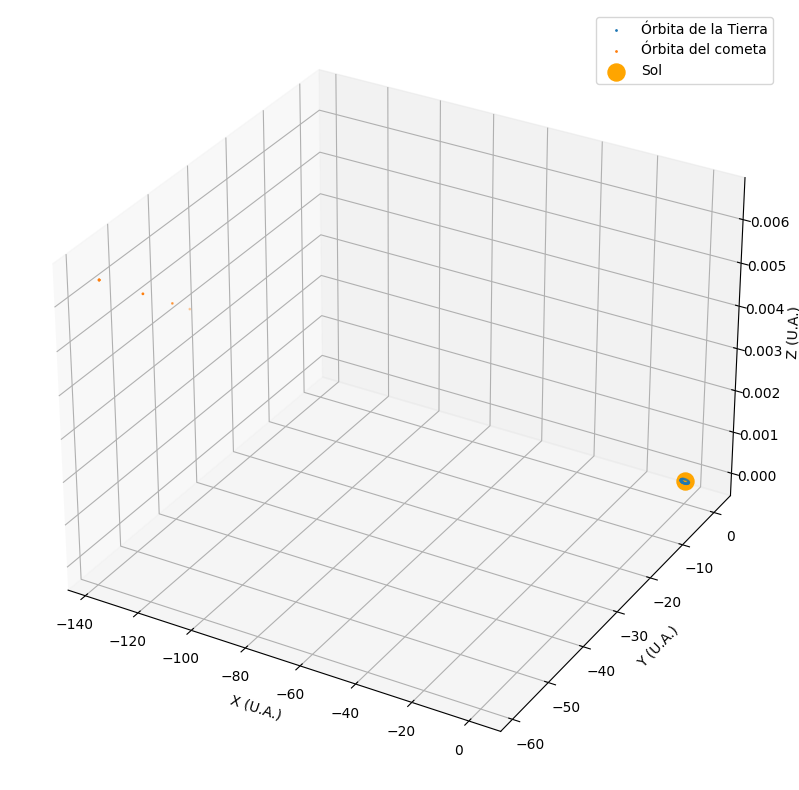

In [5]:
coor_cometa_inicial = np.transpose(coor_cometa_inicial)
## Plot de las ótbita
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(plot_tierra_data[0], plot_tierra_data[1], plot_tierra_data[2], label='Órbita de la Tierra', s=1)
ax.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], coor_cometa_inicial[2], label='Órbita del cometa', s=1)
ax.scatter(0, 0, 0, s=150, label='Sol', color="orange")

ax.legend()
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
#ax.set_zlim(-1, 1)
ax.set_xlabel('X (U.A.)')
ax.set_ylabel('Y (U.A.)')
ax.set_zlabel('Z (U.A.)')


plt.show()

In [27]:
## Error asociado al cálculo del \phi del cometa
for ii in range (4):
    z_cometa = r_cometa_inicial[ii] * (np.sin(i_cometa[ii].value)) * np.sin(phi_cometa_inicial[ii].value)
    print(z_cometa - coor_cometa_inicial[ii][2])

-1.084395255881998e-10
0.0
-4.0301312547591506e-10
-6.455350490264244e-11
